# Short-time analysis of speech and audio signals

## The speech signal
![waveform](attachments/148294966.png)

- Speech sounds are acoustic signals

   - Emitted from the mouth
   
   - Pressure variations travelling through the air
   
   - Received by the ears
   
- The figure on the right has an example of a speech sample, together with a time-aligned phonetic and text transcription.
   
- The acoustic perssure waveform is captured by a microphone

   - The microphone converts it to an analog electric signal 
   
   - Further converted to a digital signal with an AD converter
   
   - Usually a zero-mean signal (zero is average/ambient pressure level)
   
- We will here always assume that we have access to a digital representation of the speech signal

- It is a highly time-variant signal -- it is more often changing then stationary

- Analysis tools assume that the signal is stationary

   - -> Fundamental problem!
   
   - For example, if we analyze the (Fourier) spectrum of a speech signal, we would see the spectrum of a mixture of all the phonemes.
   
   - -> Not useful!
   
- In _short-time analysis_ of speech, the signal is split into small segments (windows).
    - If windows are short enough, signal is stationary
    - Can use standard DSP tools within windows



## Sound example
Let's take a demonstration sound.

In [93]:
# Initialization
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import scipy.fft
import numpy as np

fs = 48000  # Sample rate - modify this to match your device (=try changing if the code below complains about sample rate)
seconds = 5  # Duration of recording

filename = 'sounds/windowing_test.wav'

In [94]:
# read from storage
fs, data = wavfile.read(filename)
data = data[:,0]

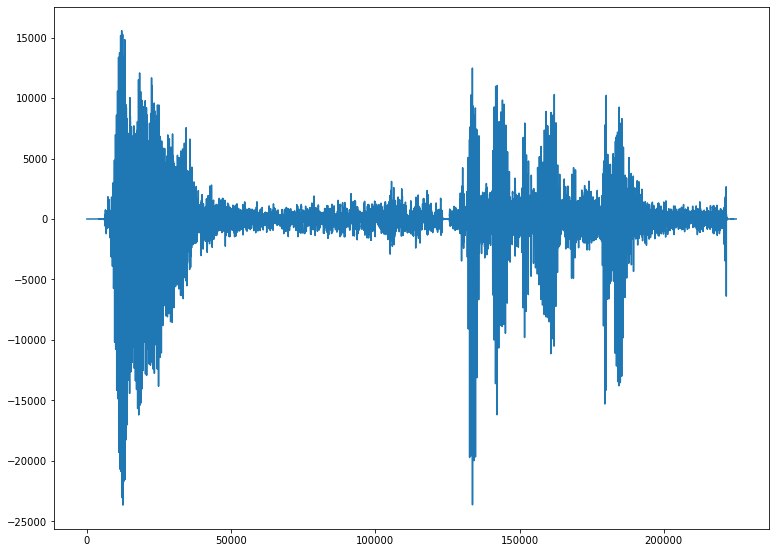

In [95]:
import IPython
IPython.display.display(IPython.display.Audio(data,rate=fs))
plt.plot(data);

## What would be a suitable window size?

- Choose a window length in milliseconds. 
- Try to find the longest window where segments still look stationary (waveform character does not change much during segment).

Window length in samples 1440


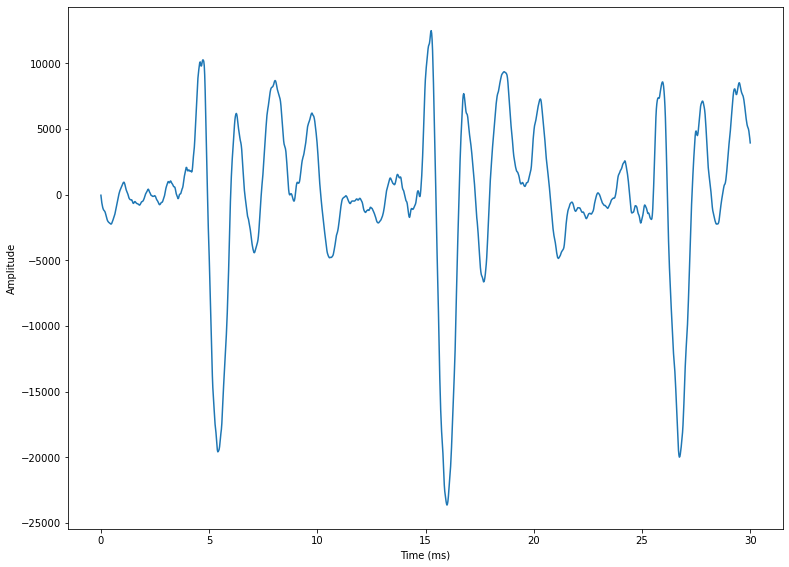

In [98]:
window_length_ms = 30

window_length = int(window_length_ms*fs/1000)
print('Window length in samples ' + str(window_length))

data_length = data.shape[0]

# choose segment from random position in sample
starting_position = np.random.randint(data_length - window_length)

time_vector = np.linspace(0,window_length_ms,window_length)

plt.plot(time_vector,data[starting_position:(starting_position+window_length)])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

- A window length in the range 20 to 30 ms typically gives fairly stationary windows.
   - An exception is plosives, like /t/ or /p/, where speech suddenly starts (i.e. onset). There we will never get a stationary waveform, but then the single event characterizes the window, so it is then a single-event window and thus "stationary" in a wide sense. 
- Longer windows would give more data to analyze = more efficient/accurate
- However, analysis methods such as Fourier analysis, typically assume that a window is stationary.
   - Breaking the assumptions reduce efficiency/accuracy

## Windowing functions

### Problem
- A signal $\{x_1,\dots x_n\}$ of a signal is equivalent with a zero-extended signal $\{0,\dots 0,\,x_1\dots x_n,\,0\dots0\}$
- Heuristic interpretation: The window looks identical to one which has a discontinuity at the border. It does not look stationary = Inaccurate and inefficient.

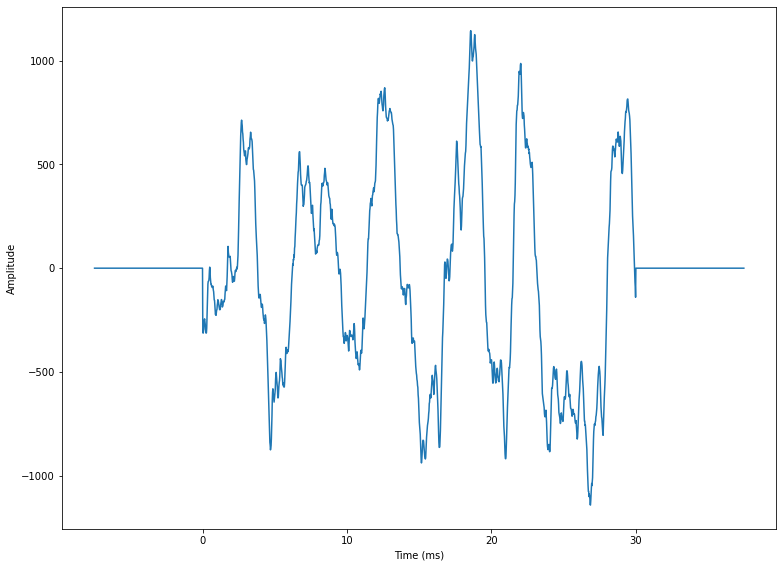

In [100]:
zero_length = int(window_length/4)
zero_length_ms = window_length_ms/4

# choose segment from random position in sample
starting_position = zero_length + np.random.randint(data_length - window_length - 2*zero_length)

time_vector = np.linspace(-zero_length_ms,window_length_ms+zero_length_ms,window_length+2*zero_length)

zero_vector = np.zeros([zero_length,])
data_vector = np.concatenate((zero_vector,data[starting_position:(starting_position+window_length)],zero_vector))


plt.plot(time_vector,data_vector)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

### Solution
- Multiply window with smooth function, the windowing function, which goes to zero at the borders.
- Local structure of the signal is not changed much = similar to original signal.
- Goes smoothly to zero at borders = no discontinuity = no problem.
- Typically, we multiply the signal $x_n$ with a windowing function $w_n$

    $$
       \tilde x_n := w_n x_n
    $$
    
    where 
    
    $$
       \begin{cases}
         w_n > 0, & N\in[0,N-1], \\
         w_n = 0, & \text{otherwise}.
       \end{cases}
    $$
    
    and $w_n$ goes smoothly to zero at the segment borders
    
    $$
    \begin{cases}
      \lim_{n\rightarrow 0}w_n &= 0, \\
      \lim_{n\rightarrow N-1}w_n &= 0      .
    \end{cases}
    $$
    
- Typical windowing functions include the Hann 

    $$ w_n = \frac12\left[1 - \cos\left(\frac{\pi \left(n+\frac12\right)}{N}\right)\right] $$

    and the Hamming windows

    $$ w_n = 0.54 - 0.46\cos\left(\frac{\pi \left(n+\frac12\right)}{N}\right). $$

- The choice of windowing function is usually based on preference with respect to resolution in the spectrum.
- More details at https://en.wikipedia.org/wiki/Window_function

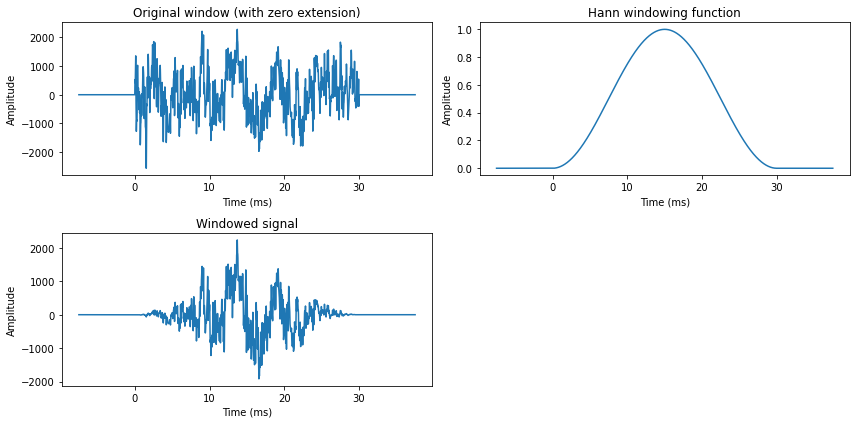

In [102]:
windowing_function = np.sin(np.pi*np.arange(0.5,window_length,1)/window_length)**2

windowing_function_extended = np.concatenate((zero_vector,windowing_function,zero_vector))

# choose segment from random position in sample
starting_position = zero_length + np.random.randint(data_length - window_length - 2*zero_length)

zero_vector = np.zeros([zero_length,])
data_vector = np.concatenate((zero_vector,data[starting_position:(starting_position+window_length)],zero_vector))

plt.figure(figsize=[12,6])

plt.subplot(221)
plt.plot(time_vector,data_vector)
plt.title('Original window (with zero extension)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(222)
plt.plot(time_vector,windowing_function_extended)
plt.title('Hann windowing function')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(223)
plt.plot(time_vector,data_vector*windowing_function_extended)
plt.title('Windowed signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

## Spectral analysis

- The discrete Fourier transform (DFT) can be used to compute the frequency spectrum

  $$
        \tilde X_k = \sum_{n=0}^{N-1} \tilde x_n e^{-i2\pi kn/N},
  $$
  
  where the windowed signal is $\tilde x_n = w_n x_n$.
- Consequences
   - The Fourier transform is $\tilde X_k = W_k*X_k$ where '$*$' is the convolution.
   - The true spectrum $X_k$ is smoothed with windowing function
   - Observation is biased (but best we can do for a non-stationary signals)

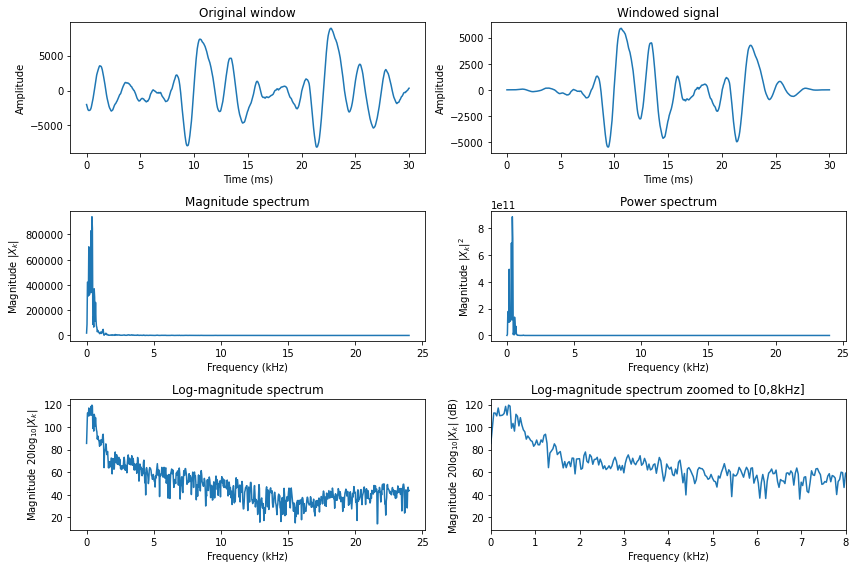

In [16]:
windowing_function = np.sin(np.pi*np.arange(0.5,window_length,1)/window_length)**2

# choose segment from random position in sample
starting_position = zero_length + np.random.randint(data_length - window_length)

# Now without the zero-extension, because that was just for illustration
data_vector = data[starting_position:(starting_position+window_length),]
time_vector = np.linspace(0,window_length_ms,window_length)
frequency_vector = np.linspace(0,fs/2000,int(window_length/2+1))

plt.figure(figsize=[12,8])

plt.subplot(321)
plt.plot(time_vector,data_vector)
plt.title('Original window')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(322)
plt.plot(time_vector,data_vector*windowing_function)
plt.title('Windowed signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(323)
plt.plot(frequency_vector,np.abs(scipy.fft.rfft(data_vector*windowing_function)))
plt.title('Magnitude spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $|X_k|$')

plt.subplot(324)
plt.plot(frequency_vector,np.abs(scipy.fft.rfft(data_vector*windowing_function))**2)
plt.title('Power spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $|X_k|^2$')

plt.subplot(325)
plt.plot(frequency_vector,20*np.log10(np.abs(scipy.fft.rfft(data_vector*windowing_function))))
plt.title('Log-magnitude spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\log_{10}|X_k|$')
ax = plt.axis()

plt.subplot(326)
plt.plot(frequency_vector,20*np.log10(np.abs(scipy.fft.rfft(data_vector*windowing_function))))
plt.title('Log-magnitude spectrum zoomed to [0,8kHz]')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\log_{10}|X_k|$ (dB)')
ax = [0, 8, ax[2], ax[3]]
plt.axis(ax)

plt.tight_layout()
plt.show()



- Observations
   - The DFT is complex-valued and cannot be easily visualized as such.
   - The absolute $|X_k|$ or absolute squared $|X_k|^2$  value of the spectrum can be plotted, but different frequencies have very different ranges so it is hard to see anything useful.
   - In the log-magnitude spectrum $\log|X_k|$  spectral features are much better visualized.
   - The usual unit is decibel, $20\log_{10}|X_k|$ (dB).
- In fact, the log-intensity scale corresponds roughly to a perceptual scale, that is, it corresponds more or less to how humans perceive loudness for individual frequencies.

## Speech features in the spectrum
### Envelope
The macro-shape of the spectrum is known as the envelope. It can be also be defined as the smooth shape which connects spectral peaks.



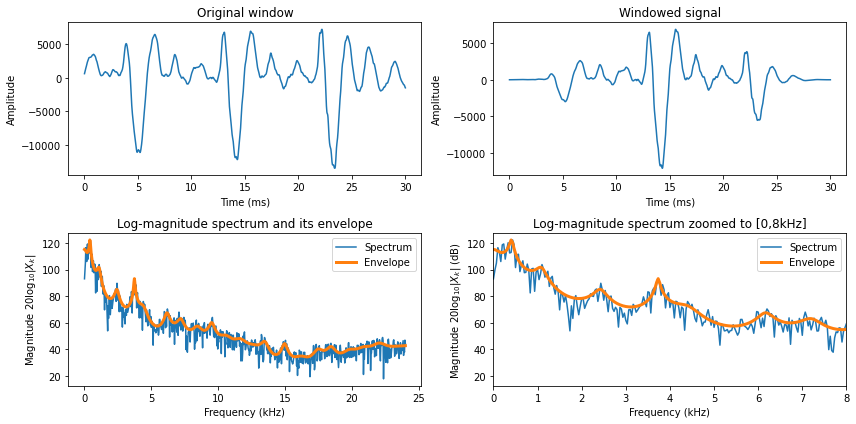

In [20]:
windowing_function = np.sin(np.pi*np.arange(0.5,window_length,1)/window_length)**2

# choose segment from random position in sample
starting_position = zero_length + np.random.randint(data_length - window_length)

# Now without the zero-extension, because that was just for illustration
data_vector = data[starting_position:(starting_position+window_length),]
time_vector = np.linspace(0,window_length_ms,window_length)
frequency_vector = np.linspace(0,fs/2000,int(window_length/2+1))

plt.figure(figsize=[12,6])


plt.subplot(221)
plt.plot(time_vector,data_vector)
plt.title('Original window')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(222)
plt.plot(time_vector,data_vector*windowing_function)
plt.title('Windowed signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')


# Envelope calculation - the theory of the mathematical methods is not covered here
from scipy.linalg import solve_toeplitz, toeplitz
autocorrelation = scipy.fft.irfft(np.abs(scipy.fft.rfft(data_vector*windowing_function))**2)
lpc_order = int(fs/1000 + 2)
u = np.zeros([lpc_order+1,1])
u[0]=1
lpc_model = solve_toeplitz(autocorrelation[0:lpc_order+1],u)
lpc_model /= lpc_model[0]
envelope_spectrum = np.abs(scipy.fft.rfft(lpc_model,window_length,axis=0))**-1
signal_spectrum = np.abs(scipy.fft.rfft(data_vector*windowing_function))
envelope_spectrum *= np.max(signal_spectrum)/np.max(envelope_spectrum)



plt.subplot(223)
plt.plot(frequency_vector,20*np.log10(signal_spectrum),label='Spectrum')
plt.plot(frequency_vector,20*np.log10(envelope_spectrum),linewidth=3,label='Envelope')
plt.legend()
plt.title('Log-magnitude spectrum and its envelope')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\log_{10}|X_k|$')
ax = plt.axis()

plt.subplot(224)
plt.plot(frequency_vector,20*np.log10(signal_spectrum),label='Spectrum')
plt.plot(frequency_vector,20*np.log10(envelope_spectrum),linewidth=3,label='Envelope')
plt.legend()
plt.title('Log-magnitude spectrum zoomed to [0,8kHz]')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\log_{10}|X_k|$ (dB)')
ax = [0, 8, ax[2], ax[3]]
plt.axis(ax)

plt.tight_layout()
plt.show()



### Formants
- Peaks of the envelope are known as _formants_. They are thus high-energy areas of the spectrum. The formants are numbered from left to right, F1, F2, F3 etc.
- The location of formants uniquely identify vowels. In other words, each vowel is defined by a unique combination of the two first formants.

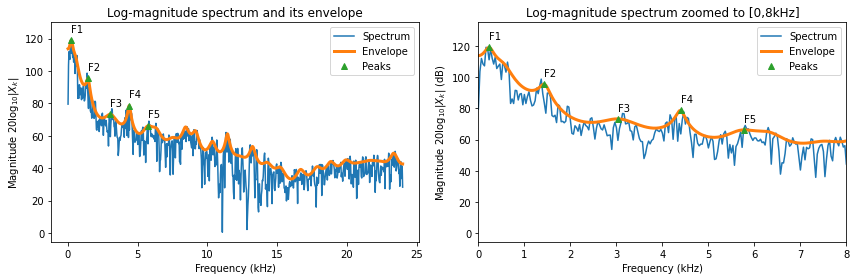

In [21]:
windowing_function = np.sin(np.pi*np.arange(0.5,window_length,1)/window_length)**2

# choose segment from random position in sample
starting_position = zero_length + np.random.randint(data_length - window_length)

# Now without the zero-extension, because that was just for illustration
data_vector = data[starting_position:(starting_position+window_length),]
time_vector = np.linspace(0,window_length_ms,window_length)
frequency_vector = np.linspace(0,fs/2000,int(window_length/2+1))

# Envelope calculation - the theory of the mathematical methods is not covered here
from scipy.linalg import solve_toeplitz, toeplitz
autocorrelation = scipy.fft.irfft(np.abs(scipy.fft.rfft(data_vector*windowing_function))**2)
lpc_order = int(fs/1000 + 2)
u = np.zeros([lpc_order+1,1])
u[0]=1
lpc_model = solve_toeplitz(autocorrelation[0:lpc_order+1],u)
lpc_model /= lpc_model[0]
envelope_spectrum = np.abs(scipy.fft.rfft(lpc_model,window_length,axis=0))**-1
signal_spectrum = np.abs(scipy.fft.rfft(data_vector*windowing_function))
envelope_spectrum *= np.max(signal_spectrum)/np.max(envelope_spectrum)

# Find peaks of envelope
## Derivative is zero at peaks and valleys; similarly, the first difference changes sign.
## At peaks, the first difference changes sign from positive negative
diff_envelope = np.diff(envelope_spectrum,axis=0)
sign_diff_envelope = np.sign(diff_envelope)
diff_sign_diff_envelope = np.diff(sign_diff_envelope,axis=0)
peak_indices = np.argwhere(diff_sign_diff_envelope[:,0] < 0)+1
peak_indices = peak_indices[0:5]

plt.figure(figsize=[12,4])

plt.subplot(121)
plt.plot(frequency_vector,20*np.log10(signal_spectrum),label='Spectrum')
plt.plot(frequency_vector,20*np.log10(envelope_spectrum),linewidth=3,label='Envelope')
plt.plot(frequency_vector[peak_indices],20*np.log10(envelope_spectrum[peak_indices,0]),marker='^',linestyle='',label='Peaks')
for k in range(len(peak_indices)): 
    x = frequency_vector[peak_indices[k]]
    y = 20*np.log10(envelope_spectrum[peak_indices[k],0]) + 5
    plt.text(x,y,'F' + str(k+1))    
plt.legend()
plt.title('Log-magnitude spectrum and its envelope')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\log_{10}|X_k|$')
ax = plt.axis()
ax = [ax[0], ax[1], ax[2], ax[3]+5]
plt.axis(ax)

plt.subplot(122)
plt.plot(frequency_vector,20*np.log10(signal_spectrum),label='Spectrum')
plt.plot(frequency_vector,20*np.log10(envelope_spectrum),linewidth=3,label='Envelope')
plt.plot(frequency_vector[peak_indices],20*np.log10(envelope_spectrum[peak_indices,0]),marker='^',linestyle='',label='Peaks')
for k in range(len(peak_indices)): 
    x = frequency_vector[peak_indices[k]]
    y = 20*np.log10(envelope_spectrum[peak_indices[k],0]) + 5
    if x < 8:  plt.text(x,y,'F' + str(k+1))    
plt.legend()
plt.title('Log-magnitude spectrum zoomed to [0,8kHz]')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\log_{10}|X_k|$ (dB)')
ax = [0, 8, ax[2], ax[3]+5]
plt.axis(ax)

plt.tight_layout()
plt.show()



### Fundamental frequency

Note: A more thorough description of the fundamental frequency is found at [Fundamental frequency](Fundamental%20frequency.ipynb).

Voiced phonations are "more or less" periodic or equivalently, we call them quasi-periodic. The periodicity is generated by the vocal folds which oscillate in the airflow, periodically closing the passing airflow to open again, with a frequency approximately in the range 80 to 400 Hz. It is visible in the waveform as a repeated waveform, in the spectrum as a comb-structure, that is, relatively densly spaced peaks in the spectrum.

The fundamental frequency is often called the F0. It is a bit of an unfortunate choice, because it can be confused to the formants, which are F1, F2, F3, although there is no connection between formants and the fundamental frequency.

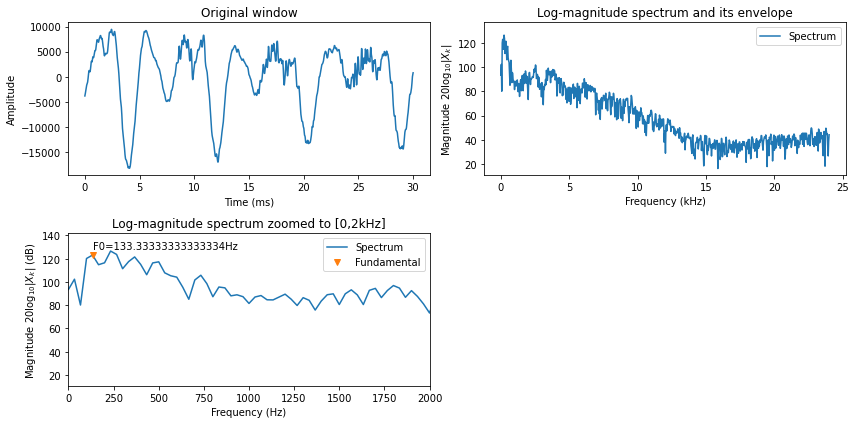

In [31]:
windowing_function = np.sin(np.pi*np.arange(0.5,window_length,1)/window_length)**2

# choose segment from random position in sample
starting_position = zero_length + np.random.randint(data_length - window_length)

# Now without the zero-extension, because that was just for illustration
data_vector = data[starting_position:(starting_position+window_length),]
time_vector = np.linspace(0,window_length_ms,window_length)
frequency_vector = np.linspace(0,fs/2000,int(window_length/2+1))

signal_spectrum = np.abs(scipy.fft.rfft(data_vector*windowing_function))

# Find fundamental frequency peak
## Derivative is zero at peaks and valleys; similarly, the first difference changes sign.
## At peaks, the first difference changes sign from positive negative
diff_envelope = np.diff(signal_spectrum,axis=0)
sign_diff_envelope = np.sign(diff_envelope)
diff_sign_diff_envelope = np.diff(sign_diff_envelope,axis=0)
peak_indices = np.argwhere(diff_sign_diff_envelope[:] < 0)[:,0]+1
peak_frequencies = frequency_vector[peak_indices]*1000

# Suppose F0 is in the range 80 to 400, then the highest peak in that range belongs to the comb structure
in_range_indices = np.argwhere((peak_frequencies >= 80) & (peak_frequencies <= 400))[:,0]
if in_range_indices.size > 0:
    largest_index = np.argmax(signal_spectrum[peak_indices[in_range_indices]])
    within_6dB = np.argwhere(signal_spectrum[peak_indices[in_range_indices]] > signal_spectrum[peak_indices[largest_index]]*0.5)
    F0_index = peak_indices[in_range_indices[within_6dB[0]] ]
    

plt.figure(figsize=[12,6])

plt.subplot(221)
plt.plot(time_vector,data_vector)
plt.title('Original window')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')


plt.subplot(222)
plt.plot(frequency_vector,20*np.log10(signal_spectrum),label='Spectrum')
#plt.plot(frequency_vector[peak_indices],20*np.log10(envelope_spectrum[peak_indices,0]),marker='^',linestyle='',label='Peaks')
#for k in range(len(peak_indices)): 
#    x = frequency_vector[peak_indices[k]]
#    y = 20*np.log10(envelope_spectrum[peak_indices[k],0]) + 5
#    plt.text(x,y,'F' + str(k+1))    
plt.legend()
plt.title('Log-magnitude spectrum and its envelope')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\log_{10}|X_k|$')
ax = plt.axis()
ax = [ax[0], ax[1], ax[2], ax[3]+5]
plt.axis(ax)

plt.subplot(223)
plt.plot(frequency_vector*1000,20*np.log10(signal_spectrum),label='Spectrum')
plt.plot(frequency_vector[F0_index]*1000,20*np.log10(signal_spectrum[F0_index]),marker='v',linestyle='',label='Fundamental')
plt.text(frequency_vector[F0_index]*1000,20*np.log10(signal_spectrum[F0_index]) + 5,'F0='+str(frequency_vector[F0_index[0]]*1000)+'Hz')
plt.legend()
plt.title('Log-magnitude spectrum zoomed to [0,2kHz]')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude $20\log_{10}|X_k|$ (dB)')
ax = [0, 2000, ax[2], ax[3]+5]
plt.axis(ax)

plt.tight_layout()
plt.show()



#### Harmonics of the fundamental

Observe that voiced signals are [harmonic](https://en.wikipedia.org/wiki/Harmonic). That is, when the glottal folds oscillate, the main event in each oscillation is when the glottal folds smash into each other. This event forms a node in the waveform, which means that all sub-components of the waveform must align at this point. If the length of the glottal period is $T$, then any waveform which has the length $T/k$, where $k$ is a positive integer would then be periodic with length $T$. The frequencies of the harmonics are correspondingly $kF_0$, for a fundamental $F_0$. 

In other words, in the spectrum, we will see a sequence of peaks at frequencies $kF_0$. Such a structure is known as a comb-structure.

Observe that the demonstration code will always return _some_ fundamental frequency, even if the signal does not really have any periodicity. Similarly, it will always show a harmonic structure even if there is none. This is though a typical feature of speech analysis; measurements are noisy at best, and sometimes the desired effect is not even present at all. The software however must be somehow able to cope with that.

Typical errors in the observation are
- Sometimes there is no fundamental frequency, but a harmonic model will still be plotted
- Sometimes the fundamental frequency estimate is inaccurate, such that the higher harmonics are very much inaccurate (why?)
- Sometimes a multiple of the fundamental is incorrectly identified as the fundamental. Then the identified harmonics only cover some of the true harmonics.

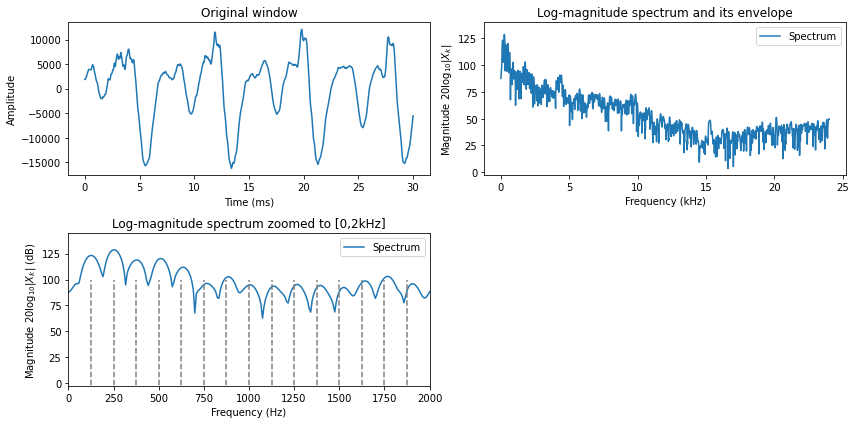

In [118]:
windowing_function = np.sin(np.pi*np.arange(0.5,window_length,1)/window_length)**2

# choose segment from random position in sample
starting_position = zero_length + np.random.randint(data_length - window_length)

# Now without the zero-extension, because that was just for illustration
data_vector = data[starting_position:(starting_position+window_length),]
time_vector = np.linspace(0,window_length_ms,window_length)

signal_spectrum = np.abs(scipy.fft.rfft(data_vector*windowing_function,n=window_length*4))
frequency_vector = np.linspace(0,fs/2000,len(signal_spectrum))

# Find fundamental frequency peak
## Derivative is zero at peaks and valleys; similarly, the first difference changes sign.
## At peaks, the first difference changes sign from positive negative
diff_envelope = np.diff(signal_spectrum,axis=0)
sign_diff_envelope = np.sign(diff_envelope)
diff_sign_diff_envelope = np.diff(sign_diff_envelope,axis=0)
peak_indices = np.argwhere(diff_sign_diff_envelope[:] < 0)[:,0]+1
peak_frequencies = frequency_vector[peak_indices]*1000

# Suppose F0 is in the range 80 to 400, then the highest peak in that range belongs to the comb structure
in_range_indices = np.argwhere((peak_frequencies >= 80) & (peak_frequencies <= 400))[:,0]
if in_range_indices.size > 0:
    largest_index = np.argmax(signal_spectrum[peak_indices[in_range_indices]])
    within_6dB = np.argwhere(signal_spectrum[peak_indices[in_range_indices]] > signal_spectrum[peak_indices[largest_index]]*0.5)
    F0_index = peak_indices[in_range_indices[within_6dB[0]] ]
    
    

plt.figure(figsize=[12,6])
    
plt.subplot(221)
plt.plot(time_vector,data_vector)
plt.title('Original window')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')


plt.subplot(222)
plt.plot(frequency_vector,20*np.log10(signal_spectrum),label='Spectrum')
plt.legend()
plt.title('Log-magnitude spectrum and its envelope')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\log_{10}|X_k|$')
ax = plt.axis()
ax = [ax[0], ax[1], ax[2], ax[3]+5]
plt.axis(ax)


plt.subplot(223)
plt.plot(frequency_vector*1000,20*np.log10(signal_spectrum),label='Spectrum')
F0vector = np.arange(frequency_vector[F0_index],2,frequency_vector[F0_index])
for h in F0vector:
    plt.plot(h*np.ones(2)*1000,[-100,100],linestyle='--',color='gray')
plt.legend()
plt.title('Log-magnitude spectrum zoomed to [0,2kHz]')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude $20\log_{10}|X_k|$ (dB)')
ax = [0, 2000, ax[2], ax[3]+5]
plt.axis(ax)

plt.tight_layout()
plt.show()



## Spectrogram



One window gives a "snapshot" image of the signal.
Analysis of multiple, consecutive windows give a "movie". We can therefore analyze how the signal is changing over time.

We use a sliding window

$$
\tilde x_{n,k} = w_{n-k} x_n
$$

where each value of $k$ gives a different snapshot of the signal.

By taking the DFT of each window, we obtain the _short-time Fourier transform (STFT)_, which can be plotted as a _spectrogram_-representation of the signal. Since many of the fundamental features of speech signals are visible in the spectrum, we can then expect to see the same features also in the spectrogram. Moreover, we will be able to see how these features change over time.

Algorithm:
1. At position $k$, apply windowing (typically, Hamming windowing)
    to obtain segment of the signal of length $N$.
2. Apply the fast Fourier transform to obtain the spectrum $X_k(\omega)$.
3. Take the logarithm of the absolute value $20\log_{10}|X_k(\omega)|$ to obtain
    the logarithmic spectrum.
4. Advance position by $K$, that is, $k:=k+K$ and return to 1. 


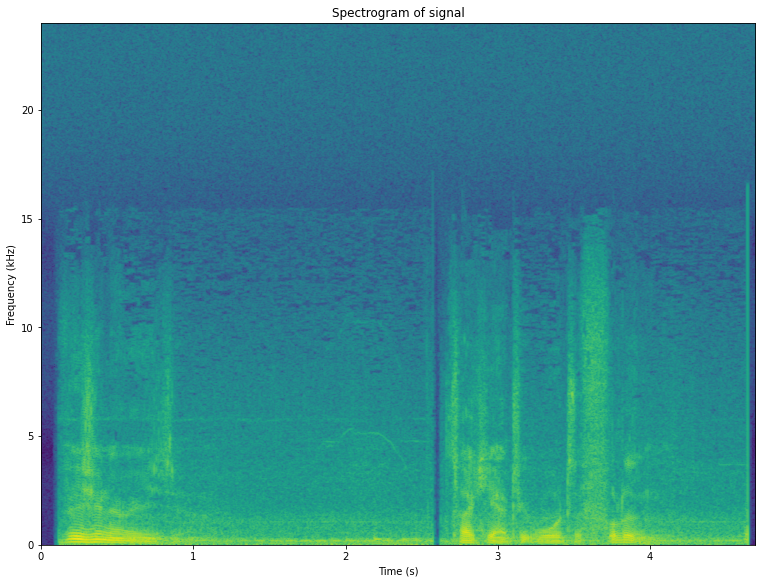

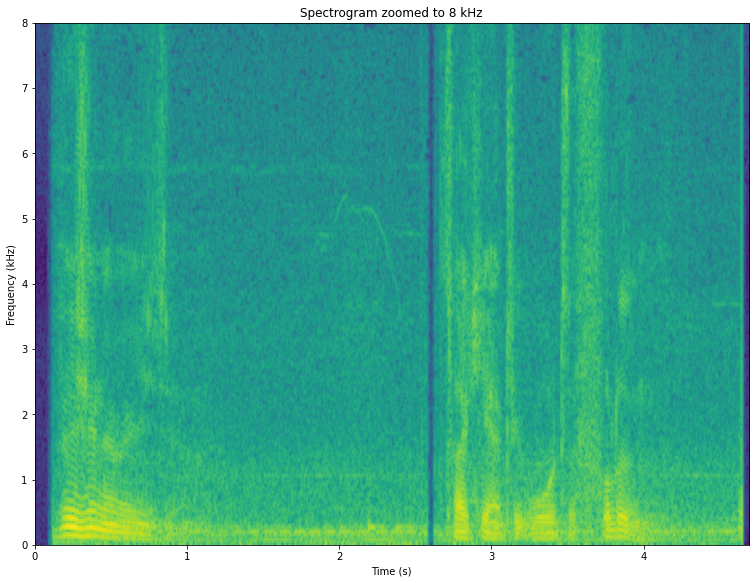

In [85]:
window_step = int(window_length/8) # step between analysis windows
window_count = int(np.floor((len(data)-window_length)/window_step)+1)
spectrum_length = int((window_length+1)/2)+1

spectrogram = np.zeros((window_count,spectrum_length))
time_vector = np.linspace(0,window_length_ms,window_length)
frequency_vector = np.linspace(0,fs/2000,spectrum_length)


for k in range(window_count):
    starting_position = k*window_step
    
    data_vector = data[starting_position:(starting_position+window_length),]
    window_spectrum = np.abs(scipy.fft.rfft(data_vector*windowing_function))
    
    spectrogram[k,:] = window_spectrum


black_eps = 1e-1 # minimum value for the log-value in the spectrogram - helps making the background really black
    
import matplotlib as mpl
default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [val*2 for val in default_figsize]
plt.imshow(20*np.log10(np.abs(np.transpose(spectrogram))+black_eps),aspect='auto',origin='lower',extent=[0, len(data)/fs,0, fs/2000])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.title('Spectrogram of signal')
plt.show()

mpl.rcParams['figure.figsize'] = [val*2 for val in default_figsize]
plt.imshow(20*np.log10(np.abs(np.transpose(spectrogram))+black_eps),aspect='auto',origin='lower',extent=[0, len(data)/fs,0, fs/2000])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.axis([0, len(data)/fs, 0, 8])
plt.title('Spectrogram zoomed to 8 kHz')
plt.show()



#### Exercise
- What is the fundamental, its harmonics and where can you see them change?
- Where are the formants?
- Can you find vertical lines in the plot? Listen to the corresponding audio; can you find out what the vertical lines correspond to?

#### Accuracy

The resolution or accuracy of the spectrogram depends on
- Step between windows
- Length of windows
- Amount of zero-extension of signal
- Shape of windowing function

We will discuss each (except the shape of the windowing function) below. 

Analyzing windows is similar to sampling a signal. The more often you take windows (or samples), the higher the resolution over time will be. The price is a larger amount of data. Moreover, at some point, there really is not that much to be gained by a denser sampling. Similarly, we can reduce the density to lower computationaly cost, but at some point you start loosing essential information.

The number of points in the spectrum corresponds to the length of the vector given to the DFT. That is, a longer window will give more spectral components and thus a higher spectral resolution. More accurate is good in the sense that, for example, from a accurate spectrum we can estimate the fundamental frequency more accurately. However, the compromise is due to the inherent changes in speech signals. Because speech signals are continuosly changing, when we take longer windows, we will more frequently have instances where a single window contains two or more distinct sounds, such that the spectrum is a combination of these sounds. The spectrum is then smeared and less accurate, even if we wanted to get a more accurate spectrum. This is a compromise where we have to always seek a balance depending on the objectives in each particular application.

A second method for increasing the accuracy of the spectrum is known as zero-extension. It is somewhat artificial in the sense that it does not actually bring any new information to the analysis. It is achieved by simply extending the windowed signal by zeros. Since it thus has more samples, the spectrum will have more resolution. We can then, for example, find a more accurate estimate of the fundamental frequency. However, since zero-extension does not introduce any new information into the analysis, it should be treated as a interpolation method and it thus gives an interpolated spectrum. In analysis applications that is often a desirable feature.

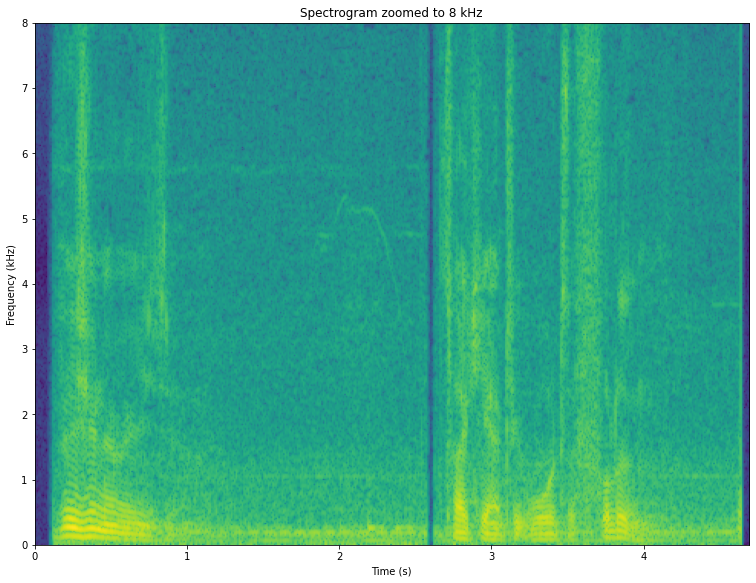

In [37]:
# try different length, step and zero-extension factors
window_length_ms = 30
window_step_ms = 10
zero_extension_factor = 1 # multiplicator by which we extend the length of the spectrum

# derived parameters
window_length = int(window_length_ms*fs/1000)
window_step = int(window_step_ms*fs/1000)
total_length = int(window_length*zero_extension_factor)


window_count = int(np.floor((len(data)-window_length)/window_step)+1)
spectrum_length = int((total_length+1)/2)+1
windowing_function = np.sin(np.pi*np.arange(0.5,window_length,1)/window_length)**2

spectrogram = np.zeros((window_count,spectrum_length))
time_vector = np.linspace(0,window_length_ms,window_length)
frequency_vector = np.linspace(0,fs/2000,spectrum_length)


for k in range(window_count):
    starting_position = k*window_step
    
    data_vector = data[starting_position:(starting_position+window_length),]
    window_spectrum = np.abs(scipy.fft.rfft(data_vector*windowing_function,n=total_length))
    
    spectrogram[k,:] = window_spectrum


black_eps = 1e-1 # minimum value for the log-value in the spectrogram - helps making the background really black
    
import matplotlib as mpl
default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [val*2 for val in default_figsize]

mpl.rcParams['figure.figsize'] = [val*2 for val in default_figsize]
plt.imshow(20*np.log10(np.abs(np.transpose(spectrogram))+black_eps),aspect='auto',origin='lower',extent=[0, len(data)/fs,0, fs/2000])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.axis([0, len(data)/fs, 0, 8])
plt.title('Spectrogram zoomed to 8 kHz')
plt.show()



### Speech features visible in the spectrogram

- Comb-structure of the fundamental frequency F0 is visible as horizontal lines. Changes in F0 over time can be easily followed.
- Time-structure of speech is clearly visible. We can spot breaks in speech as well as changes in phonemes.
- Unvoiced phonemes (speech sounds without a fundamental frequency) are also visible. Typically sustained consonants (fricatives, such as /h/ or /s/) have noise at the high frequencies.
    Stop consonants (/p/, /k/, /t/) are short wide-band bursts.


## Short-time spectral analysis summary
We have presented a spectral _analysis_ methods for speech.
- Spectral analysis can nicely visualise many of the most important
    features of speech signals.
- The decibel scale corresponds roughly to perceptual sensitivity.
- Short-time Fourier transform is the most common speech analysis method.
- Spectrogram is visualizes spectral behaviour over time. 
